
# Imputation par régression linéaire multiple

>**Présentation**
>
>Il s'agit d'utiliser la méthode de regression linéaire multiple afin de remplacer les 37 données manquantes de la variable margin_low.
>
>Les données sont organisées en 7 variables quantitatives et 1500 lignes.
>
>Nous vérifirons aussi les hypothèses de la régression.

In [1]:
# Nous importons les librairies nécessaires à l'étude

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functions import *

In [2]:
# Importation des données et préparation du DF

df=pd.read_csv('billets.csv',sep=';')
df=df.rename(columns={'is_genuine':'cible'})
df['cible'] = df['cible'].astype(str)
df['cible'] = df['cible'].str.lower()
df['cible'] = np.where(df['cible']=='true',1,0)
df

,cible,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


In [3]:
# On réccupère les valeurs nulles
miss_value = df[df['margin_low'].isnull()]

In [4]:
# On supprimme les données manquantes
df_reg=df.dropna()
len(df_reg)

1463

### Régression avec toutes les variables  <a class="anchor" id="Partie_1"></a> 

In [5]:
reg_multiple=smf.ols('margin_low ~ cible + height_left + height_right + margin_up + length',data=df_reg).fit()
print(reg_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.1
Date:                Wed, 06 Apr 2022   Prob (F-statistic):          2.23e-300
Time:                        08:45:18   Log-Likelihood:                -774.20
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7806      6.025      0.130   

>Il y a un énorme problème de multicolinéarité selon Python    
Aucune variable n'est significatif

In [6]:
# Pour détecter la multicollinéarité
variables = reg_multiple.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[4.658690317916859,
 1.1677906470666537,
 1.3176616835122352,
 1.594910481751497,
 3.6104343040574087]

> Dans la litérature statistique, il est donné comme seuil 5 ou 10, à ne pas dépasser.    
Ici, il n'y a pas du tout de collinéarité entre les variables. 

> Le problème vient d'ailleur => surement un problème d'hétéroscédasticité des erreurs

### Normalité des résidus      <a class="anchor" id="Partie_8"></a> 

In [7]:
residu_s_multi = reg_multiple.resid

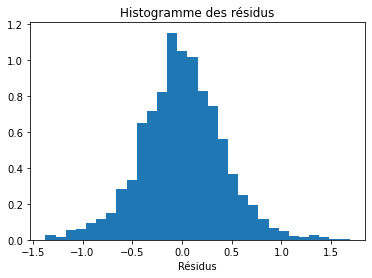

In [8]:
plt.hist(residu_s_multi, density=True,bins=30)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

>Il est difficil de juger de la normalité des résidus avec ce graphique.    
Nous pouvons tester la normalité des résidus, avec un test de **Shapiro-Wilk**.

In [9]:
shapiro(reg_multiple.resid)

ShapiroResult(statistic=0.9936385750770569, pvalue=6.365746230585501e-06)

>Ici, l'hypothèse de normalité est remise en cause  car : p-value = 0.00006 < 0.05.


### Etude des points leviers

In [10]:
alpha=0.05
n=df_reg.shape[0]
p=4

>Nous allons analyser les valeurs atypiques ou abérantes du modèle.   
>Le seuil du levier est donné par la formule

### $$\frac {2p}{n}$$    


In [11]:
analyses=pd.DataFrame({'obs':np.arange(1,n+1)})
analyses['levier'] = reg_multiple.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

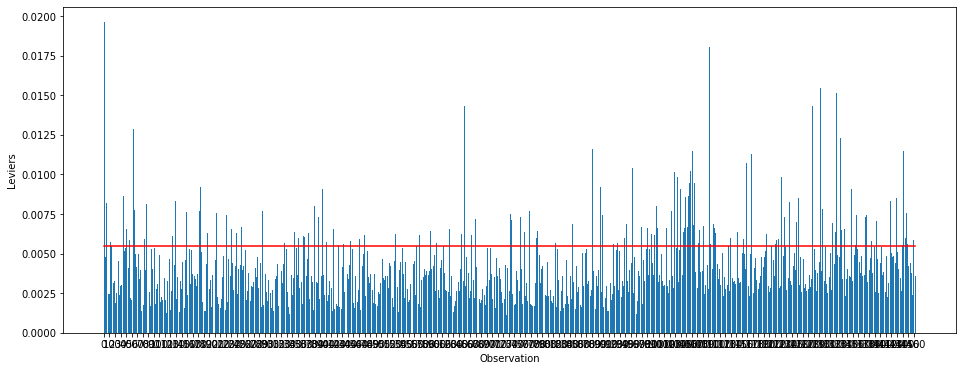

In [12]:
plt.figure(figsize=(16,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1462, step=10))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1462], [seuil_levier, seuil_levier], color='r')
plt.show()

### Interprétation
>Toutes les bars bleu au dessus de la ligne rouge sont autant de points leviers dans le modèle.     
Nous rappelons que les points leviers sont les individus qui modifient significativement le trend de la regression

***
### Homoscédasticité des résidus   <a class="anchor" id="Partie_7"></a> 


>Nous pouvons également tester l’homoscédasticité, c'est-à-dire la constance de la variance des résidus :
****

In [13]:
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(reg_multiple.resid, variables)
print('p value test Breusch Pagan:', round(pval,4))

p value test Breusch Pagan: 0.0


#### Interprétation
>La p-valeur ici n'est pas inférieure à $5$%,      
on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).     

 > Il y a bien hétéroscédasticité des erreurs

### Standardisation des erreurs   <a class="anchor" id="Partie_4"></a> 

In [14]:
# Nous créons une colonne avec les erreurs normalisées (studentisées)
analyses['rstudent'] = reg_multiple.get_influence().resid_studentized_internal

# Nous récupérons le seuil à 5%, 1.96 comme les erreurs suivent une loi normale standardisée (0,1)
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

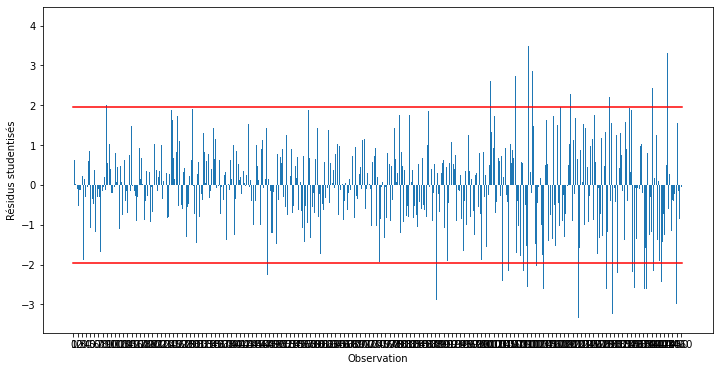

In [15]:
plt.figure(figsize=(12,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1462, step=10))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1462], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1462], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

#### Interprétation
> Visuellement l'hétéroscédasticité est flagrante    
Plus la variable cible augmente et plus la variance des erreurs augmente

### Regression Backward

> On peut résoudre le problème d'hétéroscédascité en modifiant le modèle et en supprimant certaines variables, les moins significatives.    
Nous les retirons du modèle une par une en utilisant une reggression backward.

In [16]:
columns = ['margin_low','cible','height_left','height_right','margin_up','length']
reg_backward = backward_selected(df_reg[columns], 'margin_low')

_______________________________
margin_low ~ height_right + cible + length + margin_up + height_left + 1
remove length (p-value : 0.876 )

_______________________________
margin_low ~ height_right + cible + margin_up + height_left + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ cible + margin_up + height_left + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ cible + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Wed, 06 Apr 2022   Prob (F-statistic):          1.24e-304
Time:                        08:45:28   Log-Likelihood:                -774.73
No. Observations:                1463   AI

In [17]:
# On reccupère les objets d'une regression linéaire multiple avec statmodel

reg_multiple_2=smf.ols('margin_low ~ cible + margin_up ',data=df_reg).fit()

### Vérification visuelle de l'homoscédasticité

In [18]:
# Nous créons une colonne avec les erreurs normalisées (studentisées)
analyses['rstudent'] = reg_multiple_2.get_influence().resid_studentized_internal

# Nous récupérons le seuil à 5%, 1.96 comme les erreurs suivent une loi normale standardisée (0,1)
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

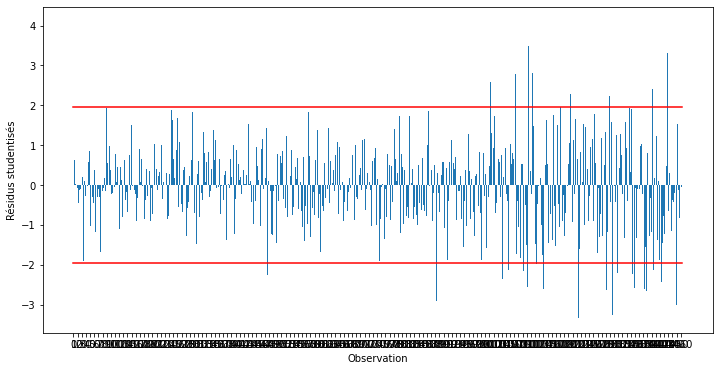

In [19]:
plt.figure(figsize=(12,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1462, step=10))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1462], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1462], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

### Interprétation 
>Le modèle est **moyennement** satisfaisant avec       
=> $R^2$=0.617      
=> **Skewness** proche de 0 => les résidus sont presque centrés   
=> **Kurtosis** proche de 3     
=> Les 2 variables et la constante sont tout de même significatif

> De plus le problème d'homoscédsticidé n'a pas été reglé.   

### Prévision

In [20]:
# On crée un df contenant uniquement les variables cibles et margin_up des 37 données manquantes

miss_value_prev = miss_value.drop(columns=['diagonal','height_left','height_right','margin_low','length'])

In [21]:
# Création d'une liste contenant les valeurs calculées de la variable margin_up

margin_low_prev = reg_multiple_2.predict(miss_value_prev)

In [22]:
# Remplacement des valeurs nulles par les valeurs prédites

df.loc[df["margin_low"].isnull(), 'margin_low'] = margin_low_prev